In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import gamma, pareto, lognorm
from scipy.optimize import minimize


data = pd.read_csv("danishRe.csv")
data.head()
Y = data['Loss'].values

         Date      Loss
0  1980-01-03  1.683748
1  1980-01-04  2.093704
2  1980-01-05  1.732581
3  1980-01-07  1.779754
4  1980-01-07  4.612006
Number of NaN values in each column:
Date    0
Loss    0
dtype: int64


In [ ]:
# Option 1: Gamma
alpha_MM = np.mean(Y)**2 / np.var(Y)
sigma_MM = np.var(Y) / np.mean(Y)

def neg_log_likelihood_gamma(params):
    alpha, sigma = params
    return -np.sum(np.log(gamma.pdf(Y, a=alpha, scale=sigma)))

result_gamma = minimize(neg_log_likelihood_gamma, x0=[alpha_MM, sigma_MM], bounds=[(0.01, None), (1, 40)])
alpha_gamma, sigma_gamma = result_gamma.x
print("Option 1: Gamma")
print("Alpha:", alpha_gamma)
print("Sigma:", sigma_gamma)

# Option 2: Pareto
n = len(Y)
theta = 1
alpha_pareto = n / (np.sum(np.log(Y)) - n * np.log(theta))
print("\nOption 2: Pareto")
print("Alpha:", alpha_pareto)
print("Theta:", theta)


mu = np.mean(np.log(Y))
sigma = np.std(np.log(Y))
print("\nOption 3: Lognormal")
print("Mu:", mu)
print("Sigma:", sigma)


Option 1: Gamma
Alpha: 1.297607672889709
Sigma: 2.6087106280515395

Option 2: Pareto
Alpha: 1.2707286340264616
Theta: 1

Option 3: Lognormal
Mu: 0.7869500798383489
Sigma: 0.7165545131176423


Three models are proposed: Gamma, Pareto and Lognormal to model the $Y$ losses. We estimate the parameters by maximum likelihood:

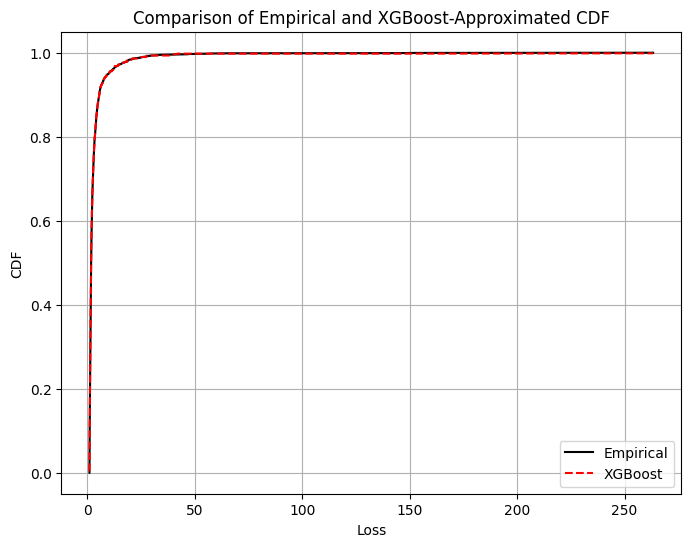

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xgboost as xgb
import pandas as pd

X = np.sort(Y).reshape(-1, 1)  # Features
y = np.arange(1, len(Y)+1) / len(Y)  # Target variable (empirical CDF)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X)

plt.figure(figsize=(8, 6))
plt.plot(X.flatten(), y, label='Empirical', color='black')
plt.plot(X.flatten(), predictions, label='XGBoost', color='red', linestyle='--')

plt.xlabel('Loss')
plt.ylabel('CDF')
plt.title('Comparison of Empirical and XGBoost-Approximated CDF')
plt.legend()
plt.grid(True)
plt.show()


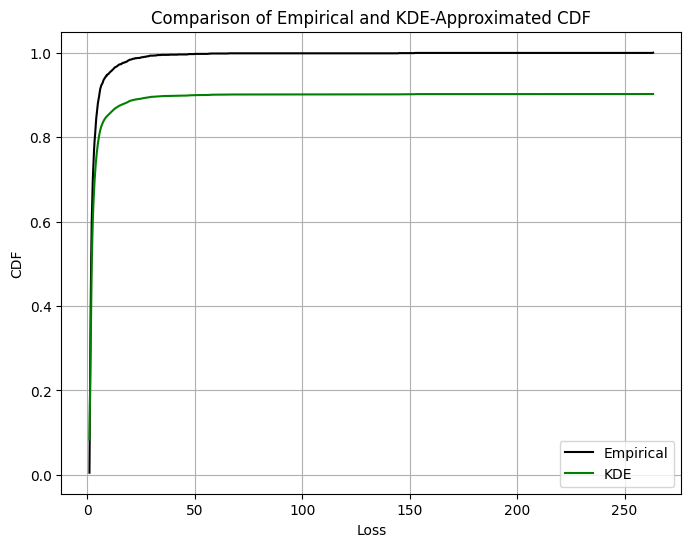

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity


x_values = np.linspace(np.min(Y), np.max(Y), 1000)

empirical_cdf = np.searchsorted(np.sort(Y), x_values, side='right') / len(Y)

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(Y[:, np.newaxis])

kde_pdf = np.exp(kde.score_samples(x_values[:, np.newaxis]))

kde_cdf = np.cumsum(kde_pdf) * (x_values[1] - x_values[0])

plt.figure(figsize=(8, 6))
plt.plot(x_values, empirical_cdf, label='Empirical', color='black')
plt.plot(x_values, kde_cdf, label='KDE', color='green')

plt.xlabel('Loss')
plt.ylabel('CDF')
plt.title('Comparison of Empirical and KDE-Approximated CDF')
plt.legend()
plt.grid(True)
plt.show()


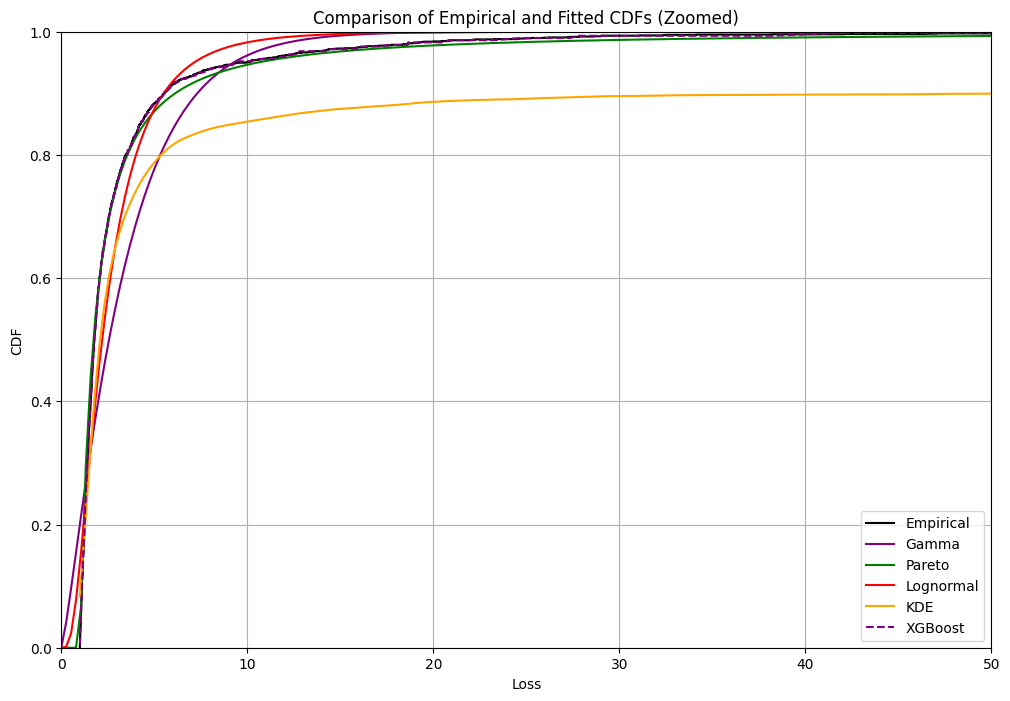

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, pareto, lognorm
from sklearn.neighbors import KernelDensity
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv("danishRe.csv")
Y = data['Loss'].values

datos_exponencial = Y


def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(data)+1) / len(data)
    return x, y


alpha_gamma = 1.297607672889709
sigma_gamma = 2.6087106280515395

alpha_pareto = 1.2707286340264616
theta_pareto = 1

mu_lognorm = 0.7869500798383489
sigma_lognorm = 0.7165545131176423


plt.figure(figsize=(12, 8))
x_ecdf, y_ecdf = ecdf(datos_exponencial)
plt.step(x_ecdf, y_ecdf, label='Empirical', color='black')

x_gamma = np.linspace(0, np.max(datos_exponencial), 1000)
y_gamma = gamma.cdf(x_gamma, alpha_gamma, scale=sigma_gamma)
plt.plot(x_gamma, y_gamma, label='Gamma', color='purple')


x_pareto = np.linspace(0, np.max(datos_exponencial), 1000)
y_pareto = pareto.cdf(x_pareto, alpha_pareto, scale=theta_pareto)
plt.plot(x_pareto, y_pareto, label='Pareto', color='green')


x_lognorm = np.linspace(0, np.max(datos_exponencial), 1000)
y_lognorm = lognorm.cdf(x_lognorm, s=sigma_lognorm, scale=np.exp(mu_lognorm))
plt.plot(x_lognorm, y_lognorm, label='Lognormal', color='red')

x_values = np.linspace(np.min(Y), np.max(Y), 1000)


empirical_cdf = np.searchsorted(np.sort(Y), x_values, side='right') / len(Y)


kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(Y[:, np.newaxis])


kde_pdf = np.exp(kde.score_samples(x_values[:, np.newaxis]))


kde_cdf = np.cumsum(kde_pdf) * (x_values[1] - x_values[0])


plt.plot(x_values, kde_cdf, label='KDE', color='orange')


X = np.sort(Y).reshape(-1, 1)
y = np.arange(1, len(Y)+1) / len(Y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = xgb.XGBRegressor()
model.fit(X_train, y_train)

predictions = model.predict(X)

plt.plot(X.flatten(), predictions, label='XGBoost', color='purple', linestyle='--')

plt.xlim(0, 50)
plt.ylim(0, 1)

plt.xlabel('Loss')
plt.ylabel('CDF')
plt.title('Comparison of Empirical and Fitted CDFs (Zoomed)')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from scipy.stats import gamma, pareto, lognorm


alpha_gamma = 1.297607672889709
sigma_gamma = 2.6087106280515395

alpha_pareto = 1.2707286340264616
theta_pareto = 1

mu_lognorm = 0.7869500798383489
sigma_lognorm = 0.7165545131176423


class GammaEstimator(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return gamma.cdf(X, alpha_gamma, scale=sigma_gamma)

class ParetoEstimator(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return pareto.cdf(X, alpha_pareto, scale=theta_pareto)

class LognormalEstimator(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return lognorm.cdf(X, s=sigma_lognorm, scale=np.exp(mu_lognorm))


gamma_estimator = GammaEstimator()
pareto_estimator = ParetoEstimator()
lognormal_estimator = LognormalEstimator()

xgb_model = xgb.XGBRegressor()

models = [gamma_estimator, pareto_estimator, lognormal_estimator, xgb_model]
model_names = ['Gamma', 'Pareto', 'Lognormal', 'XGBoost']

for model, name in zip(models, model_names):
    cv_scores = cross_val_score(model, Y.reshape(-1, 1), Y, cv=5, scoring='neg_mean_squared_error')
    mse_mean = -cv_scores.mean()
    print("Mean Squared Error ({}): {:.4f}".format(name, mse_mean))


Mean Squared Error (Gamma): 79.2932
Mean Squared Error (Pareto): 78.9923
Mean Squared Error (Lognormal): 79.1192
Mean Squared Error (XGBoost): 15.9673
